In [288]:
#sentiments libraries
import pandas as pd
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package vader_lexicon to C:\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1. Reddit Data

In [289]:
reddit = pd.read_csv('new_reddit.csv', encoding='utf-8-sig')
reddit['TEXT']= reddit['TEXT'].astype(str)
print(reddit.shape)
reddit.head()

(5979, 7)


,SCORE,ID,SUBREDDIT,NUM_COMMENTS,TIMESTAMP,TIME_OF_DAY,TEXT
0,45,g94qma,SuggestALaptop,0,2020/04/28 09:06:12,Morning,Ignore Private Messages Suggesting Laptops The...
1,42,ekkvox,SuggestALaptop,2,2020/01/06 15:23:07,Afternoon,SuggestALaptop Stress Test Project! Submit Vie...
2,16,gqt1pd,SuggestALaptop,15,2020/05/27 00:20:20,Night,I need a laptop for gaming coding video editin...
3,5,gqv6vt,SuggestALaptop,1,2020/05/27 03:22:56,Night,So I can't buy this yet? If I can buy it where...
4,16,gqp7ra,SuggestALaptop,30,2020/05/26 19:15:01,Evening,Alienware M15 vs Lenovo Y740? Any thoughts on ...


In [290]:
sentiments = []
for line in reddit.TEXT:
    pol_score = analyser.polarity_scores(line)
    pol_score['TEXT'] = line
    sentiments.append(pol_score)

In [291]:
df_reddit_sentiments = pd.DataFrame.from_records(sentiments)
df_reddit_sentiments.rename(columns = {'TEXT':'reddit_text'}, inplace = True)
df_reddit_sentiments.head()

,neg,neu,pos,compound,reddit_text
0,0.079,0.812,0.108,0.7184,Ignore Private Messages Suggesting Laptops The...
1,0.030,0.833,0.137,0.9408,SuggestALaptop Stress Test Project! Submit Vie...
2,0.015,0.818,0.166,0.9883,I need a laptop for gaming coding video editin...
3,0.051,0.785,0.164,0.9577,So I can't buy this yet? If I can buy it where...
4,0.000,0.905,0.095,0.8753,Alienware M15 vs Lenovo Y740? Any thoughts on ...


In [292]:
df_reddit_sentiments['sentiments'] = 0
df_reddit_sentiments.loc[df_reddit_sentiments['compound'] > 0.05, 'sentiments'] = 1
df_reddit_sentiments.loc[df_reddit_sentiments['compound'] < -0.05, 'sentiments'] = -1
print(df_reddit_sentiments.shape)
df_reddit_sentiments.head()

(5979, 6)


,neg,neu,pos,compound,reddit_text,sentiments
0,0.079,0.812,0.108,0.7184,Ignore Private Messages Suggesting Laptops The...,1
1,0.030,0.833,0.137,0.9408,SuggestALaptop Stress Test Project! Submit Vie...,1
2,0.015,0.818,0.166,0.9883,I need a laptop for gaming coding video editin...,1
3,0.051,0.785,0.164,0.9577,So I can't buy this yet? If I can buy it where...,1
4,0.000,0.905,0.095,0.8753,Alienware M15 vs Lenovo Y740? Any thoughts on ...,1


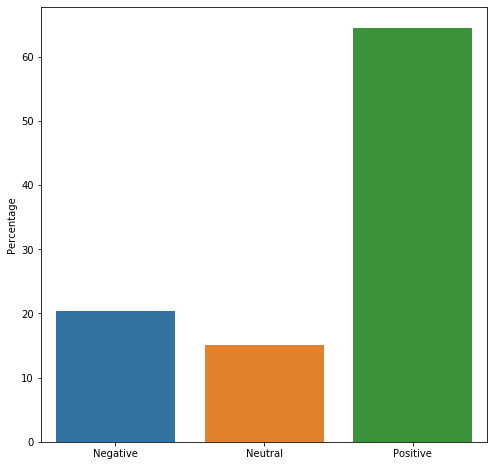

In [293]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df_reddit_sentiments.sentiments.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [294]:
#append to original dataframe
reddit.reset_index(drop=True, inplace=True)
df_reddit_sentiments.reset_index(drop=True, inplace=True)
df_redditSentiments = pd.concat([reddit, df_reddit_sentiments], axis=1)
#drop unnecessary column
df_redditSentiments = df_redditSentiments.drop(["reddit_text"], axis=1)
#change column names
df_redditSentiments.rename(columns = {'neg':'NEG'}, inplace = True)
df_redditSentiments.rename(columns = {'neu':'NEU'}, inplace = True)
df_redditSentiments.rename(columns = {'pos':'POS'}, inplace = True)
df_redditSentiments.rename(columns = {'compound':'COMPOUND'}, inplace = True)
df_redditSentiments.rename(columns = {'sentiments':'SENTIMENTS'}, inplace = True)
print(df_redditSentiments.shape)
df_redditSentiments.head()

(5979, 12)


,SCORE,ID,SUBREDDIT,NUM_COMMENTS,TIMESTAMP,TIME_OF_DAY,TEXT,NEG,NEU,POS,COMPOUND,SENTIMENTS
0,45,g94qma,SuggestALaptop,0,2020/04/28 09:06:12,Morning,Ignore Private Messages Suggesting Laptops The...,0.079,0.812,0.108,0.7184,1
1,42,ekkvox,SuggestALaptop,2,2020/01/06 15:23:07,Afternoon,SuggestALaptop Stress Test Project! Submit Vie...,0.030,0.833,0.137,0.9408,1
2,16,gqt1pd,SuggestALaptop,15,2020/05/27 00:20:20,Night,I need a laptop for gaming coding video editin...,0.015,0.818,0.166,0.9883,1
3,5,gqv6vt,SuggestALaptop,1,2020/05/27 03:22:56,Night,So I can't buy this yet? If I can buy it where...,0.051,0.785,0.164,0.9577,1
4,16,gqp7ra,SuggestALaptop,30,2020/05/26 19:15:01,Evening,Alienware M15 vs Lenovo Y740? Any thoughts on ...,0.000,0.905,0.095,0.8753,1


In [295]:
#save the dataframe as csv file
df_redditSentiments.to_csv('reddit_sentiments.csv', index = False, header=True, encoding='utf-8-sig')

In [296]:
text = " ".join(review for review in df_redditSentiments.TEXT)

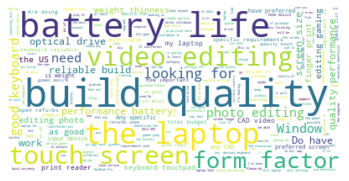

In [297]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["wa", "ha", "thi", "one"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 2. Comments under Subreddits Data

In [298]:
comments = pd.read_csv('new_comments.csv', encoding='utf-8-sig')
comments.head()

,ID,SUBREDDIT,NEW_COMMENTS
0,ekkvox,SuggestALaptop,have questions our Discord Server is best way ...
1,ekkvox,SuggestALaptop,Can anyone help me out purchasing a laptop for...
2,gqt1pd,SuggestALaptop,Ask chewy
3,gqt1pd,SuggestALaptop,Looks like a great deal at that price!
4,gqt1pd,SuggestALaptop,Ideapad or yoga whatever they are called where...


In [299]:
sentiments_3 = []
for line in comments.NEW_COMMENTS:
    pol_score = analyser.polarity_scores(line)
    pol_score['NEW_COMMENTS'] = line
    sentiments_3.append(pol_score)

In [300]:
df_comments_sentiments = pd.DataFrame.from_records(sentiments_3)
df_comments_sentiments.rename(columns = {'NEW_COMMENTS':'reddit_comments'}, inplace = True)
df_comments_sentiments.head()

,neg,neu,pos,compound,reddit_comments
0,0.124,0.598,0.278,0.8257,have questions our Discord Server is best way ...
1,0.000,0.857,0.143,0.7059,Can anyone help me out purchasing a laptop for...
2,0.000,1.000,0.000,0.0000,Ask chewy
3,0.000,0.420,0.580,0.7840,Looks like a great deal at that price!
4,0.000,1.000,0.000,0.0000,Ideapad or yoga whatever they are called where...


In [301]:
df_comments_sentiments['sentiments'] = 0
df_comments_sentiments.loc[df_comments_sentiments['compound'] > 0.05, 'sentiments'] = 1
df_comments_sentiments.loc[df_comments_sentiments['compound'] < -0.05, 'sentiments'] = -1
print(df_comments_sentiments.shape)
df_comments_sentiments.head()

(14465, 6)


,neg,neu,pos,compound,reddit_comments,sentiments
0,0.124,0.598,0.278,0.8257,have questions our Discord Server is best way ...,1
1,0.000,0.857,0.143,0.7059,Can anyone help me out purchasing a laptop for...,1
2,0.000,1.000,0.000,0.0000,Ask chewy,0
3,0.000,0.420,0.580,0.7840,Looks like a great deal at that price!,1
4,0.000,1.000,0.000,0.0000,Ideapad or yoga whatever they are called where...,0


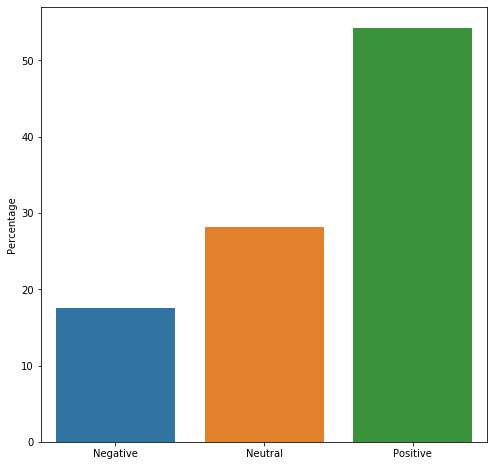

In [302]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df_comments_sentiments.sentiments.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [303]:
#append to original dataframe
comments.reset_index(drop=True, inplace=True)
df_comments_sentiments.reset_index(drop=True, inplace=True)
comments_sentiments = pd.concat([comments, df_comments_sentiments], axis=1)
#drop unnecessary column
comments_sentiments = comments_sentiments.drop(["reddit_comments"], axis=1)
#change column names
comments_sentiments.rename(columns = {'neg':'NEG'}, inplace = True)
comments_sentiments.rename(columns = {'neu':'NEU'}, inplace = True)
comments_sentiments.rename(columns = {'pos':'POS'}, inplace = True)
comments_sentiments.rename(columns = {'compound':'COMPOUND'}, inplace = True)
comments_sentiments.rename(columns = {'sentiments':'SENTIMENTS'}, inplace = True)
print(comments_sentiments.shape)
comments_sentiments.head()

(14465, 8)


,ID,SUBREDDIT,NEW_COMMENTS,NEG,NEU,POS,COMPOUND,SENTIMENTS
0,ekkvox,SuggestALaptop,have questions our Discord Server is best way ...,0.124,0.598,0.278,0.8257,1
1,ekkvox,SuggestALaptop,Can anyone help me out purchasing a laptop for...,0.000,0.857,0.143,0.7059,1
2,gqt1pd,SuggestALaptop,Ask chewy,0.000,1.000,0.000,0.0000,0
3,gqt1pd,SuggestALaptop,Looks like a great deal at that price!,0.000,0.420,0.580,0.7840,1
4,gqt1pd,SuggestALaptop,Ideapad or yoga whatever they are called where...,0.000,1.000,0.000,0.0000,0


In [304]:
#save the dataframe as csv file
comments_sentiments.to_csv('comments_sentiments.csv', index = False, header=True, encoding='utf-8-sig')

In [305]:
text = " ".join(review for review in comments_sentiments.NEW_COMMENTS)

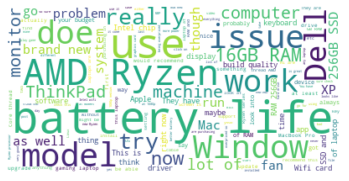

In [306]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["ha", "one"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()